In [22]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations

In [23]:
Nv = 8 # number of visible units (or number of spins in a system)
alpha = 2 # number of filters (number of hidden units Nh, Nh=alpha*Nv)
cutoff = 0.005
learning_rate = 0.01
N_steps = 100

In [24]:
#initialization of a reduced matrix of weights from normal distribution
W_reduced = np.random.normal(0, 0.01, (Nv, alpha))

In [25]:
def psi_coefficients(W_reduced, Sz):
    # Nv - number of visible units (system with Nv spins)
    # alpha=Nh/Nv, where Nh number of hidden units
    # Sz - spin configuration (Nv)
    # W_reduced - reduced matrix of weights (Nv, alpha) shape   
    Nv, alpha = W_reduced.shape 

    # use np.roll to realize a periodic boundary condition
    W_full = np.zeros((Nv, Nv * alpha)) # (Nv, Nh)
    for inx_alpha in range(alpha):
        vec = W_reduced[:, inx_alpha]
        for inx_col in range(Nv): 
            W_full[:, inx_col + Nv * inx_alpha] = np.roll(vec, inx_col)
    # calculate Theta_i = b_i + sum_{i=1}^{Nv}(W_full_{ij}Sz_{i})
    # note that b_i=0 due to the spin flip symmetry 
    theta = Sz.dot(W_full) 
    # return amplitude psi = prod_{j=1}^{Nh}(2*cosh(Theta_j))
    # the factor e^{sum_{i=1}^{Nv}(a_i*Sz_{i})}=1 due to spin flip symmetry (a_i=0)     
    return theta, np.prod(2.0 * np.cosh(theta))

In [26]:
#generation of Fock states for a given number of spins Nv
base_state = np.array([1.] * (Nv // 2) + [-1.] * (Nv // 2))
print(base_state)
num_states = 0
states = []
for state in multiset_permutations(base_state):
    num_states += 1
    states.append(state)
states = np.array(states)
print('number of states = ',num_states)
print(states.shape)

[ 1.  1.  1.  1. -1. -1. -1. -1.]
number of states =  70
(70, 8)


In [27]:
energy_vs_epoch = []
for epoch in range(N_steps):
    # create numpy array of psi coefficients corresponding to all states (psi_array).
    psi_array = []
    for state_inx in range(num_states):
        _, item_state = psi_coefficients(W_reduced, states[state_inx,:])
        psi_array.append(item_state)
    psi_array = np.array(psi_array)

    # p(S) distribution
    p_s = np.power(psi_array, 2)
    Z_norm = np.sum(p_s) 
    p_s = p_s / Z_norm

    #calculate Eloc=sum_{x'}(H_{xx'}psi(x')/psi(x))
    #for now, consider only the simple test (toy) case H=SzSz 
    E_loc_s_array = []
    for state_inx in range(num_states):
        state = states[state_inx,:]
        E_loc_s_array.append(state.dot(np.roll(state, 1)))
    E_loc_s_array = np.array(E_loc_s_array)

    #find the average energy
    Energy = E_loc_s_array.dot(p_s)
    energy_vs_epoch.append(Energy)

    #calculate the gradient of the energy with respect to variational parameters dHdw
    dHdw = np.zeros((Nv, alpha))
    for state_inx in range(num_states):
        O_wij_reduced = np.zeros((Nv, alpha))
        theta, _ = psi_coefficients(W_reduced, states[state_inx,:])
        O_wij = np.outer(states[state_inx,:], theta)

        for alpha_inx in range(alpha):
            for col_inx in range(Nv):
                act_col = col_inx + (Nv * alpha_inx) 
                O_wij[:, act_col] = np.roll(O_wij[:, act_col], -col_inx)

        for alpha_inx in range(alpha):
            left_inx = alpha_inx * Nv
            right_inx = left_inx + Nv
            #variational derivatives
            O_wij_reduced[:, alpha_inx] = np.mean(O_wij[:, left_inx:right_inx], axis = 1) 
        # dHdw=2*(<<E_loc*O_w>>-<<E_loc>>*<<O_w>>)
        dHdw += O_wij_reduced * E_loc_s_array[state_inx] * p_s[state_inx]
        dHdw -= O_wij_reduced * Energy * p_s[state_inx] 
    dHdw *= 2.  

    #update weights using gradient descent 
    delta = learning_rate * dHdw 
    W_reduced -= delta

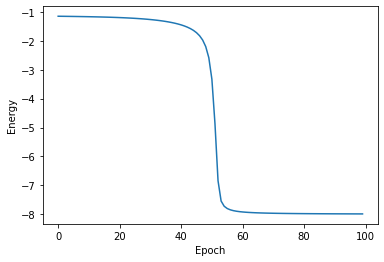

In [28]:
from matplotlib import pyplot as plt
plt.plot(energy_vs_epoch)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()